In [1]:
import os

import networkx as nx
import matplotlib.pyplot as plt

from grace.io.image_dataset import mrc_reader, ImageGraphDataset
from grace.napari.utils import EdgeColor
from grace.base import GraphAttrs
from grace.models.feature_extractor import resnet, FeatureExtractor
from grace.utils.augment_image import RandomImageGraphRotate
from grace.utils.augment_graph import RandomEdgeAdditionAndRemoval

from grace.utils.augment_image import RandomEdgeCrop
from torchvision.transforms import (
    Resize,
    Lambda,
    Normalize,
    RandomApply,
    RandomAffine,
)


In [ ]:
IMAGE_DIR = '/Users/csoelistyo/Documents/grace_files/pipeline_images/'

### Helper Code

In [ ]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

def show_image_and_graph(image, graph_data):

    fig, axes = plt.subplots(1,3, figsize=(15, 5))

    # node positions
    pos = {
        idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) 
        for idx, node in graph_data['graph'].nodes(data=True)
    }
    #pos = {k: (pos[k][1], pos[k][0]) for k in pos}
    #pos_flipped = {k: (pos[k][1],image.size()[0]-pos[k][0]) for k in pos}
    pos_flipped = {k: (pos[k][0],image.size()[1]-pos[k][1]) for k in pos}
    pos_ = [pos_flipped, pos]

    # edge annotations
    edge_gt = [data[GraphAttrs.EDGE_GROUND_TRUTH] for _,_,data in graph_data['graph'].edges(data=True)]
    edge_colors = [EdgeColor[gt.name].value for gt in edge_gt]

    node_colors = [
        EdgeColor[node_attrs[GraphAttrs.NODE_GROUND_TRUTH].name].value 
        for _, node_attrs in graph_data['graph'].nodes(data=True)
    ]

    axes[1].set_aspect('equal')
    axes[1].set_aspect(100)

    for n,ax in enumerate(axes[1:]):
        nx.draw(
            graph_data['graph'], 
            ax=ax, 
            pos=pos_[n], 
            #pos=pos,
            with_labels=False, 
            # node_color="w", 
            #node_size=32,
            node_size=2,
            edge_color=edge_colors,
            node_color=node_colors,
        )

    for ax in [axes[0], axes[2]]:
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle(graph_data['metadata']["image_filename"], y=0.95)

### Load Image and Graph (Grace File)

In [3]:
IMAGEPATH = "/Users/csoelistyo/Documents/grace_files/notebook_test/image_files"
GRACEPATH =  "/Users/csoelistyo/Documents/grace_files/notebook_test/grace_files"

In [4]:
image_graph_dataset = ImageGraphDataset(
    image_dir=IMAGEPATH,
    grace_dir=GRACEPATH,
    image_reader_fn=mrc_reader,
    transform=lambda x,y: (x,y),
)

### Show Image and Graph (No Augmentations)

In [5]:
for image, graph_data in image_graph_dataset:

    show_image_and_graph(image, graph_data)
    plt.savefig(os.path.join(IMAGE_DIR, 'full_image_raw'))

ValueError: Map ID string not found - not an MRC file, or file is corrupt

### Show Image and Graph (Rotation Augmentation)

In [52]:
image_graph_dataset = ImageGraphDataset(
    image_dir=IMAGEPATH,
    grace_dir=GRACEPATH,
    image_reader_fn=mrc_reader,
    transform=RandomImageGraphRotate(),
)

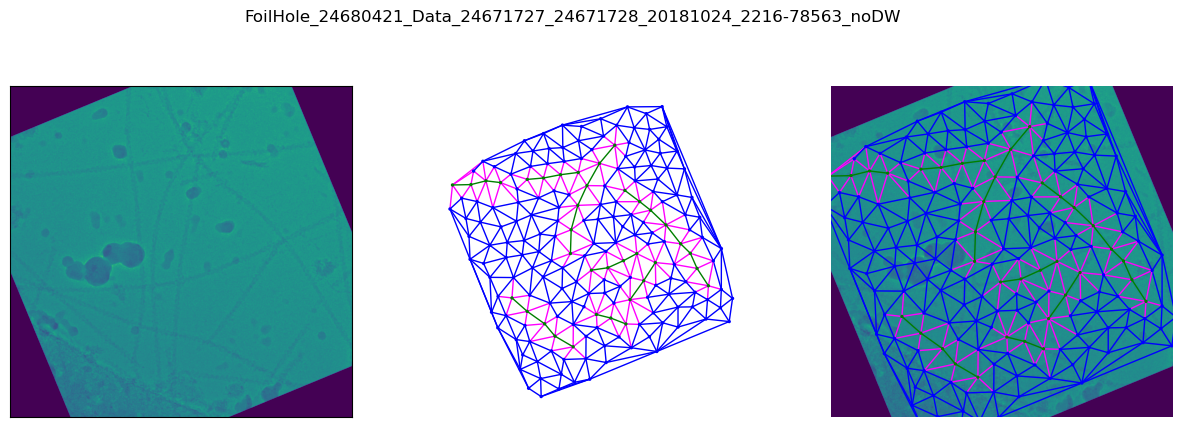

In [53]:
for image, graph_data in image_graph_dataset:

    show_image_and_graph(image, graph_data)

In [58]:
image[3720-112:3720+112].size()

torch.Size([102, 3838])

In [54]:
graph_data['graph'].nodes(data=True)[0]

{<GraphAttrs.NODE_X: 'x'>: 3720.9460289479684,
 <GraphAttrs.NODE_Y: 'y'>: 1894.233535228907,
 <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan,
 <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.UNKNOWN: 2>,
 <GraphAttrs.NODE_FEATURES: 'features'>: None}

In [55]:
image.size()

torch.Size([3710, 3838])

### Show Image and Graph (Graph Augmentation)

In [69]:
image_graph_dataset = ImageGraphDataset(
    image_dir=IMAGEPATH,
    grace_dir=GRACEPATH,
    image_reader_fn=mrc_reader,
    transform=RandomEdgeAdditionAndRemoval(annotation_mode='unknown', p_add=0.02, p_remove=0.02),
)

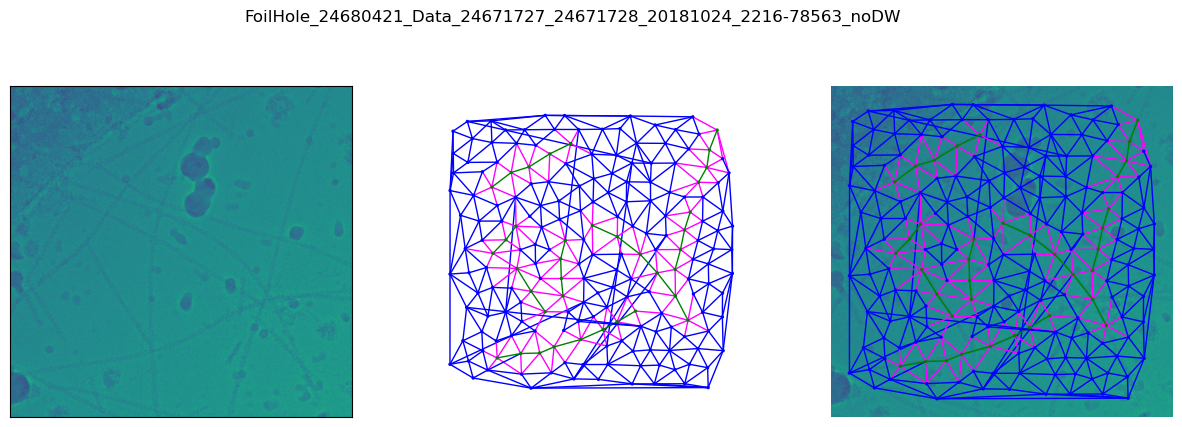

In [10]:
for image, graph_data in image_graph_dataset:

    show_image_and_graph(image, graph_data)

### Extract Bounding Boxes (No Augmentation)

In [27]:
feature_extractor = FeatureExtractor(model=lambda x: x,
                                     augmentations=lambda x: x)
image_e, graph_data_e = feature_extractor(image, graph_data)

In [29]:
image_graph_dataset = ImageGraphDataset(
    image_dir=IMAGEPATH,
    grace_dir=GRACEPATH,
    image_reader_fn=mrc_reader,
    transform=Compose([
        feature_extractor,
    ]),
)

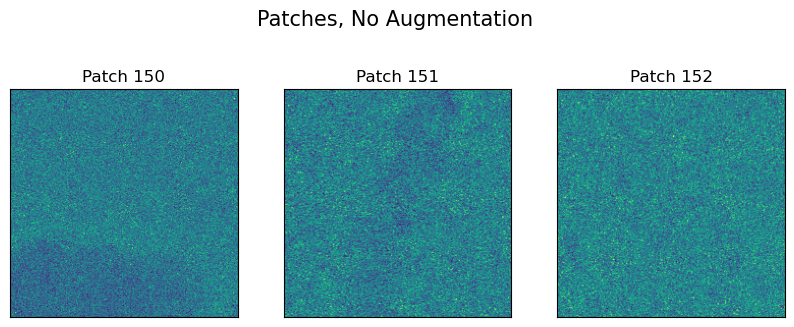

In [30]:
NODES = [150, 151, 152]

fig, axes = plt.subplots(1, len(NODES), figsize=(10,4))

for node, ax in enumerate(axes):

    patch = graph_data_e['graph'].nodes(data=True)[NODES[node]][GraphAttrs.NODE_FEATURES]
    ax.imshow(patch[0])
    ax.set_title(f"Patch {NODES[node]}")
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('Patches, No Augmentation', fontsize=15, x=.51)
plt.show()

### Extract Bounding Boxes (Rotated)

In [5]:
feature_extractor = FeatureExtractor(model=lambda x: x,
                                     augmentations=lambda x: x)


In [17]:
image_graph_dataset = ImageGraphDataset(
    image_dir=IMAGEPATH,
    grace_dir=GRACEPATH,
    image_reader_fn=mrc_reader,
    transform=Compose([
        RandomImageGraphRotate(),
        feature_extractor,
    ]),
)

/Users/csoelistyo/miniconda3/envs/grace_2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


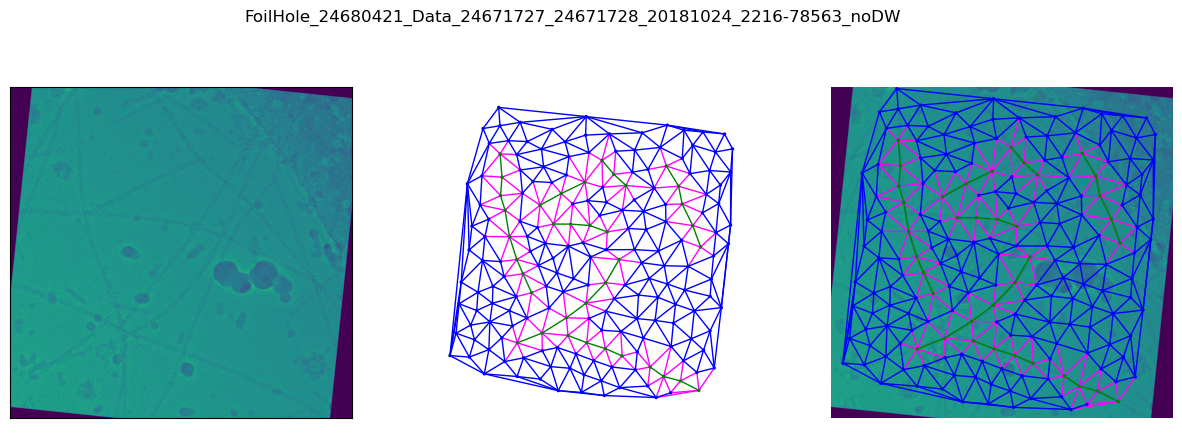

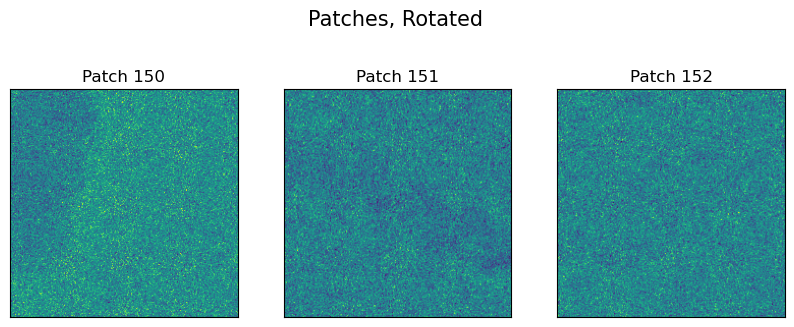

In [25]:
for image_e, graph_data_e in image_graph_dataset:

    show_image_and_graph(image_e, graph_data_e)

    NUM_NODES = 3

    fig, axes = plt.subplots(1, NUM_NODES, figsize=(10,4))
    ax_n = 0
    node = 150
    node_chosen = 0

    while node_chosen < NUM_NODES:

        patch = graph_data_e['graph'].nodes(data=True)[node][GraphAttrs.NODE_FEATURES]
        if patch is None:
            node +=1
            continue

        ax = axes[ax_n]
        ax.imshow(patch[0])
        ax.set_title(f"Patch {node}")
        ax.set_xticks([])
        ax.set_yticks([])
        ax_n += 1
        node_chosen += 1
        node +=1

    fig.suptitle('Patches, Rotated', fontsize=15, x=.51)
    plt.show()

### Apply transforms one by one 

In [7]:
import torch
for image, graph_data in image_graph_dataset:

    image_a, graph_data_a = RandomImageGraphRotate()(image, graph_data)
    #print(torch.equal(image, image_a))
    #print(nx.utils.misc.graphs_equal(graph_data['graph'], graph_data_a['graph']))
    image_a, graph_data_a = feature_extractor(image_a, graph_data_a)

/Users/csoelistyo/miniconda3/envs/grace_2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


### Extract Bounding Boxes (No Augmentation)

In [46]:
augmentations = RandomApply(
    [
        #RandomEdgeCrop(max_fraction=0.1),
        RandomAffine(
            degrees=0,
            translate=(0.2, 0.2),
        ),
    ],
    p=1.,
)

feature_extractor = FeatureExtractor(model=lambda x: x,
                                    augmentations=augmentations)

image_graph_dataset = ImageGraphDataset(
    image_dir=IMAGEPATH,
    grace_dir=GRACEPATH,
    image_reader_fn=mrc_reader,
    transform=Compose([
        RandomImageGraphRotate(),
        feature_extractor,
    ]),
)


/Users/csoelistyo/miniconda3/envs/grace_2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


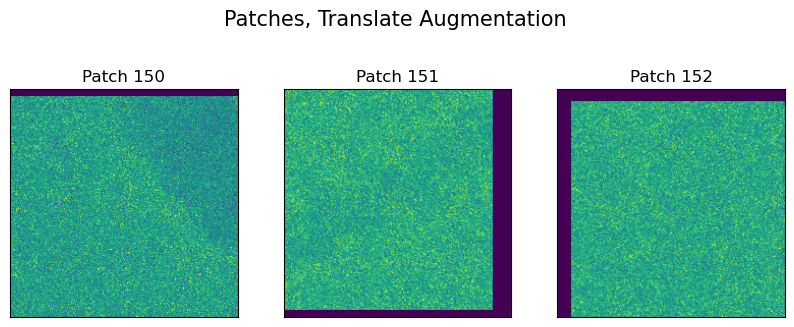

In [45]:
NODES = [150, 151, 152]

for image_e, graph_data_e in image_graph_dataset:

    fig, axes = plt.subplots(1, len(NODES), figsize=(10,4))

    for node, ax in enumerate(axes):

        patch = graph_data_e['graph'].nodes(data=True)[NODES[node]][GraphAttrs.NODE_FEATURES]
        ax.imshow(patch[0])
        ax.set_title(f"Patch {NODES[node]}")
        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle('Patches, Translate Augmentation', fontsize=15, x=.51)
    plt.savefig('')
    plt.show()